# Event log correlations 

In [1]:
### IMPORT ###
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
# pip install sns

from scipy.stats import pearsonr, shapiro, kstest, norm, probplot, spearmanr
from scipy import stats

# pip install scipy

### LOCAL IMPORT ###
from config import config_reader

In [2]:
### GLOBALS ###
yaml_config = config_reader.config_read_yaml("config.yml", "config")
# print(yaml_config) # debug
csv_sep = ","
# INPUT
log_dir = str(yaml_config["LOG_DIR"]) # <-- INPUT: Set the directory name (str) containing the event log
# log_dir = "data_log" # <-- INPUT: Set the directory name (str) containing the event log
log_file_name = "edu_event_log_PAGE_raw_filtered_DISCO_ter_enr.csv" # <-- INPUT: Set the file name

id_column = "Case ID"

# FUNCTIONS

In [3]:
def compute_distribution(df: pd.DataFrame, col1: str, colum_id: str) -> None:
    """
    Analyse the distribution of a columns in a dataframe.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
        col1 (str): Name of the column.

    Returns:
        None
    """
    
    # Remove duplicate rows based on colum_id (only one row for case id is needed)
    df = df.drop_duplicates(subset=colum_id)
    
    # Remove rows with missing values in either of the two columns
    df = df.dropna(subset=[col1])
    
    # Visualisation with histogram and density plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col1], kde=True)
    plt.title(f"Distribution of '{col1}'")

    plt.show()

In [4]:
def compute_pearson_correlation(df: pd.DataFrame, col1: str, col2: str, colum_id: str) -> None:
    """
    Analyse the distribution and correlation of two columns in a dataframe.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
        col1 (str): Name of the first column.
        col2 (str): Name of the second column.

    Returns:
        None
    """

    # Remove duplicate rows based on colum_id (only one row for case id is needed)
    df = df.drop_duplicates(subset=colum_id)

    # Check for missing values in both columns
    nan_count_col1 = df[col1].isna().sum()
    nan_count_col2 = df[col2].isna().sum()
    print(f"Missing values in {col1}: {nan_count_col1}")
    print(f"Missing values in {col2}: {nan_count_col2}")

    # Remove rows with missing values in either of the two columns
    df = df.dropna(subset=[col1, col2])
    
    # Pearson correlation
    r, p = pearsonr(df[col1], df[col2])

    # Display the results
    print(f"Pearson correlation between '{col1}' and '{col2}': r = {r:.3f}, p {'< .001' if p < 0.001 else f'= {p:.3f}'}")

In [5]:
def compute_spearman_correlation(df: pd.DataFrame, col1: str, col2: str, colum_id: str) -> None:
    """
    Compute the Spearman correlation of two columns in a dataframe.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
        col1 (str): Name of the first column.
        col2 (str): Name of the second column.
        
    Returns:
        None
    """

    # Remove duplicate rows based on colum_id (only one row for case id is needed)
    df = df.drop_duplicates(subset=colum_id)

    # Check for missing values in both columns
    nan_count_col1 = df[col1].isna().sum()
    nan_count_col2 = df[col2].isna().sum()
    print(f"Missing values in {col1}: {nan_count_col1}")
    print(f"Missing values in {col2}: {nan_count_col2}")

    # Remove rows with missing values in either of the two columns
    df = df.dropna(subset=[col1, col2])

    # Spearman correlation
    r, p = spearmanr(df[col1], df[col2])

    # Display the results
    print(f"Spearman correlation between '{col1}' and '{col2}' (ρ) = {r:.3f}, p {'< .001' if p < 0.001 else f'= {p:.3f}'}")

In [6]:
def compute_shapiro_wilk_test(df: pd.DataFrame, column_name:str, colum_id: str) -> None:
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the dataframe.")
    if colum_id not in df.columns:
        raise ValueError(f"Column '{colum_id}' does not exist in the dataframe.")
    
    # Remove duplicate rows based on colum_id (only one row for case id is needed)
    df = df.drop_duplicates(subset=colum_id)

    statistic, p_value = stats.shapiro(df[column_name])
    
    print('Column:', column_name)
    print(f'Test statistic: {statistic}')
    print(f'p-value: {p_value}')

    # Interpretazione
    alpha = 0.05
    if p_value > alpha:
        print('The data on column {col_name} follow a normal distribution (we do not reject H0)')
    else:
        print('The data on column {col_name} do not follow a normal distribution (we reject H0)')

In [7]:
def compute_column_values_frequencies(df: pd.DataFrame, column_name: str, colum_id: str) -> pd.DataFrame:
    """
    Performs a frequency analysis of the values in a specified column of a dataframe, 
    removing duplicate rows based on the colum_id before analysis, and generates a vertical bar plot of the frequencies.

    Parameters:
    ----------
    df: pd.DataFrame
        The input dataframe containing the columns to analyse.
    column_name: str
        The name of the column to analyse.
    colum_id: str
        The name of the column used to identify duplicates.

    Returns:
    -------
    pd.DataFrame
        A dataframe containing the frequency analysis (value counts).
    """
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the dataframe.")
    if colum_id not in df.columns:
        raise ValueError(f"Column '{colum_id}' does not exist in the dataframe.")

    # Remove duplicate rows based on colum_id (only one row for each case id is needed)
    df = df.drop_duplicates(subset=colum_id)

    # Compute the frequency of each unique value in the specified column
    frequency_df = df[column_name].value_counts().reset_index()
    frequency_df.columns = [column_name, "Frequency"]

    plt_tile = f"Frequency analysis of '{column_name}'"

    # Plot the frequencies with blue edges for the bars
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        frequency_df[column_name],
        frequency_df["Frequency"],
        color="skyblue",
        edgecolor="black",  # Set edge colour for the bars
        linewidth=1.5      # Thickness of the edges
    )

    # Add the frequency values above the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X position (centre of the bar)
            height + 0.5,                      # Y position (slightly above the bar)
            f"{int(height)}",                  # Value text (convert to int)
            ha="center",                       # Horizontal alignment
            va="bottom",                       # Vertical alignment
            fontsize=10                         # Font size
        )

    plt.xlabel(column_name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title(plt_tile, fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.tight_layout()
    plt.show()

    return frequency_df

# MAIN

In [8]:
print(">> Setings")
print("Input file:", log_file_name)
path_log_file = Path(log_dir) /log_file_name 
print("Path file:", path_log_file)

>> Setings
Input file: edu_event_log_PAGE_raw_filtered_DISCO_ter_enr.csv
Path file: data_log/edu_event_log_PAGE_raw_filtered_DISCO_ter_enr.csv


In [9]:
print(">> Reading")
dic_t = {'Case ID':object, 'CaseLength':int, 'SUS_Tercile':int, 'Apprendimento percepito_Tercile':int, 'UEQ - Overall_Tercile':int} # column types
df_log = pd.read_csv(path_log_file, sep=csv_sep, dtype=dic_t)

>> Reading


In [10]:
print(">> Removing columns from event log not needed")
col_del_list = ['Variant', 'Variant index']
for col_del in col_del_list:
  if col_del in df_log.columns:
    print("Removig column:", col_del)
    df_log.drop(columns=col_del, inplace=True)

>> Removing columns from event log not needed


In [11]:
df_log.shape

(8092, 73)

In [12]:
print("Distinct cases:", df_log[id_column].nunique())

Distinct cases: 332


In [13]:
df_log.head(5)

,Case ID,Activity,Complete Timestamp,pageTitle,menu,pageOrder,pagePara,eventPage,click_num,dbclick_num,...,Class_Count,FN_N,FN_Q,FN_A,FN_C,FN_I,FN_CT,A_Time_s,A_Time_m,Backward_Jumps
0,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,SURVEY-END,2024-04-22 13:50:32,SURVEY-END,menu_1,1,0,PageIN,1,0,...,38.0,0.0,0.0,0.0,0.0,0.0,L,1270.0,21.17,0
1,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO,2024-04-22 14:11:42,INTRO,menu_1,1,0,PageIN,1,0,...,26.0,0.0,0.0,1.0,1.0,0.0,FA,530.0,8.83,0
2,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO-Q,2024-04-22 14:20:32,INTRO-Q,menu_1,1,0,PageIN,1,0,...,26.0,0.0,0.0,1.0,1.0,0.0,FA,32.0,0.53,0
3,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG,2024-04-22 14:21:04,PROG,menu_1,2,0,PageIN,1,0,...,26.0,0.0,0.0,1.0,1.0,0.0,FA,233.0,3.88,0
4,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG-Q,2024-04-22 14:24:57,PROG-Q,menu_1,2,0,PageIN,1,0,...,26.0,0.0,0.0,1.0,1.0,0.0,FA,17.0,0.28,0


In [14]:
df_log.columns

Index(['Case ID', 'Activity', 'Complete Timestamp', 'pageTitle', 'menu',
       'pageOrder', 'pagePara', 'eventPage', 'click_num', 'dbclick_num',
       'QuizSessionCount', 'QuizAnswerCorrectTotal', 'QuizAnswerWrongTotal',
       'QuizAnswerCorrectRatioOverCount', 'QuizAnswerCorrectRatioOverAll',
       'QuizSessionCount_P3', 'QuizAnswerCorrectTotal_P3',
       'QuizAnswerWrongTotal_P3', 'QuizAnswerCorrectRatioOverCount_P3',
       'QuizAnswerCorrectRatioOverAll_P3', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5',
       'Q_6', 'Q_7', 'Q_8', 'Q_9', 'Q_10', 'Q_11', 'Q_12', 'Q_13', 'Q_14',
       'Q_15', 'Q_16', 'Q_17', 'Q_18', 'Q_19', 'Q_20', 'Q_21', 'Q_22', 'Q_23',
       'Q_24', 'Q_25', 'Q_26', 'Q_27', 'Q_28', 'SUS',
       'Apprendimento percepito', 'UEQ - Pragmatic', 'UEQ - Hedonic',
       'UEQ - Overall', 'TotalTimeHH', 'TotalTimeMM', 'TotalTimeMM.1',
       'TotalTimeDD', 'CaseLength', 'Class', 'SUS_Tercile',
       'Apprendimento percepito_Tercile', 'UEQ - Overall_Tercile',
       'QuizAnswe

## Columns distribution

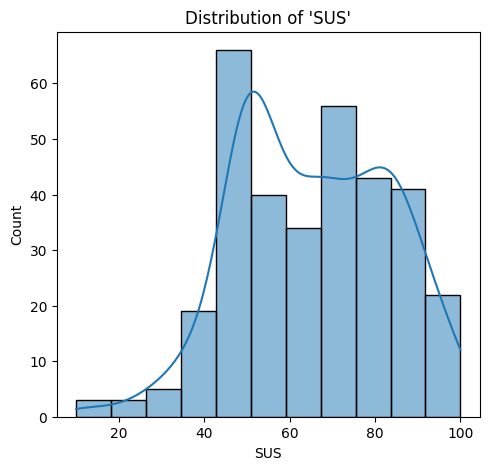

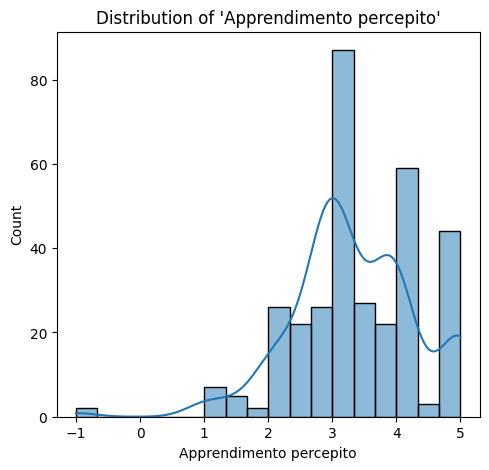

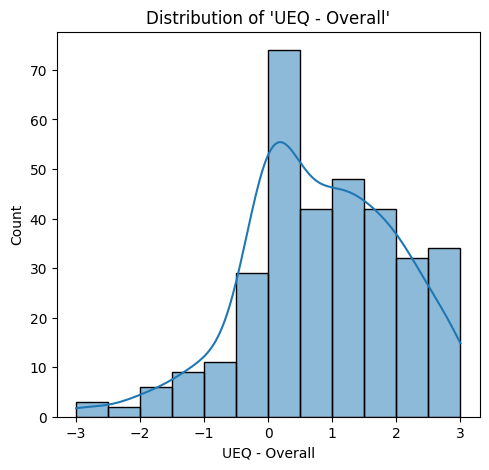

In [15]:
col_list = ['SUS', 'Apprendimento percepito', 'UEQ - Overall']
for col_name in col_list:
    compute_distribution(df_log, col_name, id_column)

## Frequency analysis

In [16]:
df_log['Apprendimento percepito'].unique().tolist()

[3.0,
 3.2,
 2.0,
 3.4,
 5.0,
 4.0,
 4.4,
 2.4,
 2.8,
 3.6,
 2.6,
 3.8,
 1.6,
 2.2,
 -1.0,
 4.8,
 1.8,
 1.4,
 4.6,
 1.0,
 4.2,
 1.2]

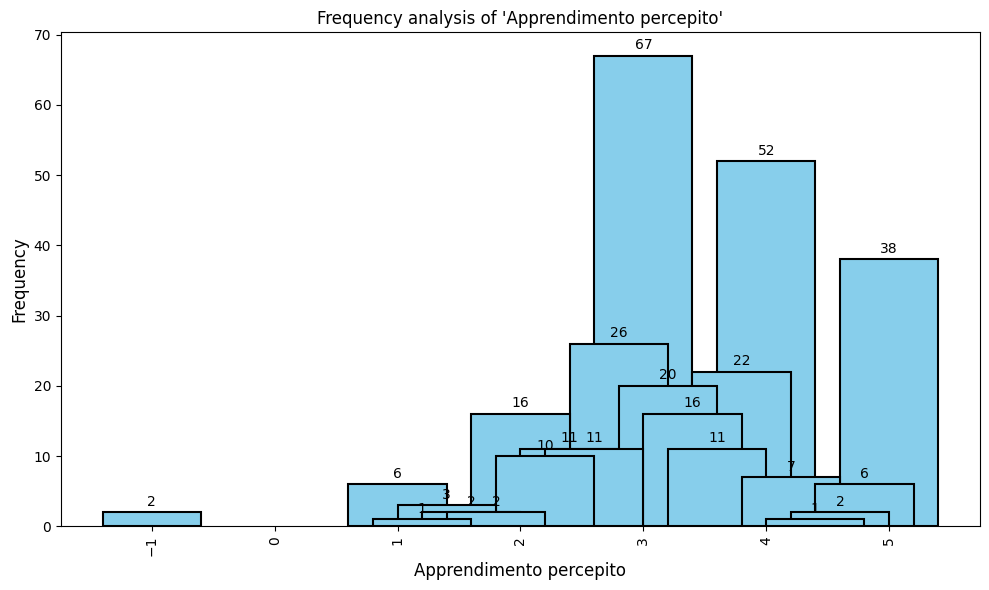

,Apprendimento percepito,Frequency
0,3.0,67
1,4.0,52
2,5.0,38
3,2.8,26
4,3.8,22
5,3.2,20
6,3.4,16
7,2.0,16
8,2.4,11
9,3.6,11


In [17]:
compute_column_values_frequencies(df_log, 'Apprendimento percepito', id_column)

## Shapiro-Wilk test

In [18]:
col_list = ['SUS', 'Apprendimento percepito', 'UEQ - Overall']
for col_name in col_list:
    compute_shapiro_wilk_test(df_log, col_name, id_column)
    print()

Column: SUS
Test statistic: 0.9727486600622063
p-value: 6.472696248317301e-06
The data on column {col_name} do not follow a normal distribution (we reject H0)

Column: Apprendimento percepito
Test statistic: 0.944951805285518
p-value: 8.749275015692844e-10
The data on column {col_name} do not follow a normal distribution (we reject H0)

Column: UEQ - Overall
Test statistic: 0.9781593145689426
p-value: 6.177579703189595e-05
The data on column {col_name} do not follow a normal distribution (we reject H0)



## Definition of columns on which computer colrrelations

In [19]:
list_couple = [("Apprendimento percepito", "QuizAnswerCorrectRatioOverAll"), ("SUS", "QuizAnswerCorrectRatioOverAll"), ("UEQ - Overall", "QuizAnswerCorrectRatioOverAll") ]
list_couple_len = len(list_couple)
print(f"Values ({list_couple_len}): {list_couple}")

Values (3): [('Apprendimento percepito', 'QuizAnswerCorrectRatioOverAll'), ('SUS', 'QuizAnswerCorrectRatioOverAll'), ('UEQ - Overall', 'QuizAnswerCorrectRatioOverAll')]


## Pearson

In [20]:
i = 0
for t in list_couple:
    i+=1
    el1 = t[0]
    el2 = t[1]
    print(f"{i}) Pearson between {el1} and {el2}")
    compute_pearson_correlation(df_log, el1, el2, id_column)
    print()

1) Pearson between Apprendimento percepito and QuizAnswerCorrectRatioOverAll
Missing values in Apprendimento percepito: 0
Missing values in QuizAnswerCorrectRatioOverAll: 1
Pearson correlation between 'Apprendimento percepito' and 'QuizAnswerCorrectRatioOverAll': r = 0.060, p = 0.277

2) Pearson between SUS and QuizAnswerCorrectRatioOverAll
Missing values in SUS: 0
Missing values in QuizAnswerCorrectRatioOverAll: 1
Pearson correlation between 'SUS' and 'QuizAnswerCorrectRatioOverAll': r = 0.203, p < .001

3) Pearson between UEQ - Overall and QuizAnswerCorrectRatioOverAll
Missing values in UEQ - Overall: 0
Missing values in QuizAnswerCorrectRatioOverAll: 1
Pearson correlation between 'UEQ - Overall' and 'QuizAnswerCorrectRatioOverAll': r = 0.094, p = 0.089



## Spearman

In [21]:
i=0
for t in list_couple:
    i+=1
    el1 = t[0]
    el2 = t[1]
    print(f"{i}) Spearman between {el1} and {el2}")
    compute_spearman_correlation(df_log, el1, el2, id_column)
    print()

1) Spearman between Apprendimento percepito and QuizAnswerCorrectRatioOverAll
Missing values in Apprendimento percepito: 0
Missing values in QuizAnswerCorrectRatioOverAll: 1
Spearman correlation between 'Apprendimento percepito' and 'QuizAnswerCorrectRatioOverAll' (ρ) = 0.066, p = 0.234

2) Spearman between SUS and QuizAnswerCorrectRatioOverAll
Missing values in SUS: 0
Missing values in QuizAnswerCorrectRatioOverAll: 1
Spearman correlation between 'SUS' and 'QuizAnswerCorrectRatioOverAll' (ρ) = 0.206, p < .001

3) Spearman between UEQ - Overall and QuizAnswerCorrectRatioOverAll
Missing values in UEQ - Overall: 0
Missing values in QuizAnswerCorrectRatioOverAll: 1
Spearman correlation between 'UEQ - Overall' and 'QuizAnswerCorrectRatioOverAll' (ρ) = 0.113, p = 0.040

